In [1]:
# ResNet50 모델 미세 튜닝
# 망을 동결하고, 1000개의 라벨을 가진 마지막 레이어를 제거
import numpy as np
import keras
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

Using TensorFlow backend.


In [2]:
# 이미지를 처리하고, ANN 피팅 진행
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input
#from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

train_datagen = ImageDataGenerator(rotation_range=10, 
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   brightness_range = [0.8, 1.2],
                                   shear_range = 0.01,
                                   zoom_range = [0.9, 1.1],
                                   validation_split = 0.1,
                                   preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(validation_split = 0.1,
                                  preprocessing_function=preprocess_input)

training_set = train_datagen.flow_from_directory('/home/ziippy/dl_data/Find_a_Car_Park/data', 
                                                 target_size=(224,224), 
                                                 classes = ['Full', 'Free'],
                                                 batch_size=32, 
                                                 shuffle=True,
                                                 subset='training',
                                                 class_mode='categorical')
val_set = val_datagen.flow_from_directory('/home/ziippy/dl_data/Find_a_Car_Park/data', 
                                          target_size=(224,224), 
                                          classes = ['Full', 'Free'],
                                          batch_size=32,
                                          shuffle=False,
                                          subset='validation',
                                          class_mode='categorical')

Found 2937 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


In [3]:
#'''
base_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
#
# 레이어 동결
for layer in model.layers:
    layer.trainable=True
#
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
#'''
'''
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=output)

for layer in model.layers:
    layer.trainable = True
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
#'''

/home/ziippy/venv/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_________________________________________________________________________________________

"\nbase_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)\nx = base_model.output\nx = GlobalAveragePooling2D()(x)\noutput = Dense(2, activation='softmax')(x) \nmodel = Model(inputs=base_model.input, outputs=output)\n\nfor layer in model.layers:\n    layer.trainable = True\n    \nmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])\nmodel.summary()\n#"

In [4]:
history = model.fit_generator(training_set, 
                              validation_data=val_set, 
                              epochs=10,
                              steps_per_epoch=len(training_set), # 32 is the batch size
                              validation_steps=len(val_set),
                              callbacks=[
                                 keras.callbacks.ModelCheckpoint('model.h5', monitor='val_acc', save_best_only=True, verbose=1)
                              ])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
92/92 [==============================] - 68s 739ms/step - loss: 0.3540 - acc: 0.9107 - val_loss: 5.0444 - val_acc: 0.5231

Epoch 00001: val_acc improved from -inf to 0.52308, saving model to model.h5
Epoch 2/10
92/92 [==============================] - 58s 632ms/step - loss: 0.1007 - acc: 0.9687 - val_loss: 0.4121 - val_acc: 0.8708

Epoch 00002: val_acc improved from 0.52308 to 0.87077, saving model to model.h5
Epoch 3/10
92/92 [==============================] - 65s 711ms/step - loss: 0.0590 - acc: 0.9813 - val_loss: 0.4880 - val_acc: 0.9415

Epoch 00003: val_acc improved from 0.87077 to 0.94154, saving model to model.h5
Epoch 4/10
92/92 [==============================] - 65s 709ms/step - loss: 0.0237 - acc: 0.9935 - val_loss: 0.0336 - val_acc: 0.9908

Epoch 00004: val_acc improved from 0.94154 to 0.99077, saving model to model.h5
Epoch 5/10
92/92 [==============================] -

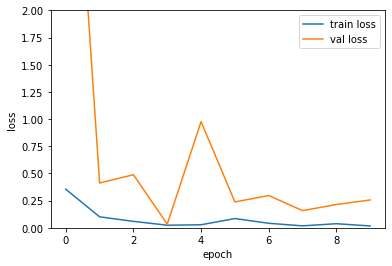

In [5]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 
#matplotlib.rcParams['figure.figsize'] = (10.0, 8.0) 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper right')

In [6]:
training_set.class_indices

{'Full': 0, 'Free': 1}

In [7]:
from keras.models import load_model
model = load_model('model.h5')
 
last_weight = model.layers[-1].get_weights()[0] # (1280, 2)
 
new_model = Model(
    inputs = model.input,
    outputs = (
        model.layers[-3].output, # the layer just before GAP, for using spatial features
        model.layers[-1].output
    )
)

94.08% Free


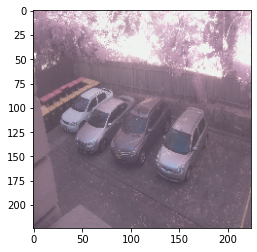

In [8]:
from keras.preprocessing import image
import numpy as np

'''
Free/img_129142058.jpg
Free/img_129173058.jpg
Free/img_724143006.jpg
Full/img_127115558.jpg
Full/img_127055603.jpg
'''

new_image = image.load_img('/home/ziippy/dl_data/Find_a_Car_Park/data/Free/img_129173058.jpg', target_size=(224,224))
plt.imshow(new_image)
new_image = image.img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)
new_image = preprocess_input(new_image)

result = model.predict(new_image)
print('%.2f%% Free' % (result[0][1] * 100))

(7, 7, 2048)


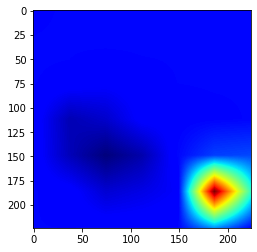

In [9]:
import scipy

last_conv_output, result = new_model.predict(new_image)

last_conv_output = np.squeeze(last_conv_output)          # (7, 7, 2048)
print(last_conv_output.shape)
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 2048) -> (224, 224, 2048)
#print(feature_activation_maps.shape)

pred_class = np.argmax(result)
predicted_class_weights = last_weight[:, pred_class] # (2048,1)
#print(predicted_class_weights.shape)

# (224*224, 2048) dot_produt (2048,1) = (224*224, 1)
final_output = np.dot(feature_activation_maps.reshape((224*224, last_conv_output.shape[2])), predicted_class_weights).reshape((224, 224))

plt.imshow(final_output, cmap='jet')

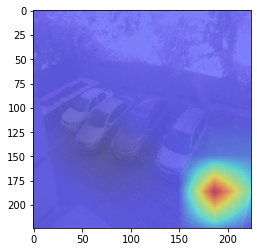

In [10]:
new_image = image.load_img('/home/ziippy/dl_data/Find_a_Car_Park/data/Free/img_129173058.jpg', target_size=(224,224))
plt.imshow(new_image, alpha=0.5)
plt.imshow(final_output, cmap='jet', alpha=0.5)